In [1]:
import pandas as pd
import nltk.data
import numpy as np
import matplotlib.pyplot as plt # plot figures
from nltk.corpus import PlaintextCorpusReader
import os, time, random, re, codecs, spacy, math, torch, spacy, transformers, nltk
from os.path import join
import seaborn as sns # plot figures
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from ipywidgets import IntProgress
from sklearn.metrics import classification_report
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
import tensorflow as tf
import sklearn.metrics as metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import plot_roc_curve
from bert_sklearn import BertClassifier
from bert_sklearn import BertRegressor
from bert_sklearn import load_model
from sklearn.model_selection import GridSearchCV
from transformers import AdamW
import torch.optim as optim
import codecs, json, copy
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from transformers.models.bert.modeling_bert import BertModel,BertForMaskedLM, BertForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore') 
import copy
import glob

In [2]:
path = '....csv'
df = pd.read_csv(path)
df = df.drop(df.columns[0], axis=1)
# df

In [3]:
path_2 = '....csv'
df_2 = pd.read_csv(path_2)
df_2 = df_2.drop(df_2.columns[0], axis=1)
# df_2

In [4]:
# Seeding:
def seed_all(seed):  
    ''' A function to seed everything for getting stable results and reproducibility'''
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed = 2021    
seed_all(seed)
# Testing size:
sizeoftest = 0.2

In [5]:
df.shape

(447, 5)

In [6]:
print(df.columns.tolist()) # column names

['end', 'file_key', 'label', 'start', 'str']


In [7]:
df.dtypes

end          int64
file_key     int64
label        int64
start        int64
str         object
dtype: object

In [8]:
df.isnull().any()

end         False
file_key    False
label       False
start       False
str         False
dtype: bool

In [9]:
df['label'].value_counts()

1    356
0     91
Name: label, dtype: int64

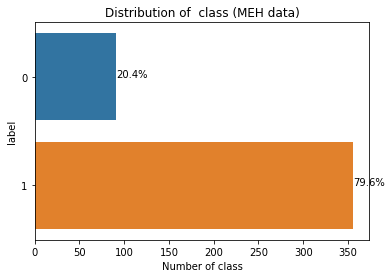

In [10]:
ax = sns.countplot(y="label", data=df)
plt.title('Distribution of  class (MEH data)')
plt.xlabel('Number of class')
total = len(df['label'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
# plt.savefig('class_label')
plt.show()

In [11]:
texts = df['str'].tolist()
labels = df['label'].tolist()
X, X_test, y, y_test = train_test_split(texts,
                                        labels,
                                        test_size=0.2,
                                        train_size=0.8,
                                        random_state=seed)
X_train, X_dev, y_train, y_dev = train_test_split(X,
                                                  y,
                                                  test_size=0.25,
                                                  train_size=0.75,
                                                  random_state=seed)
# len(X_train), len(y_train), len(X_test), len(y_test), len(X_dev), len(y_dev)
print("Train size:", len(X_train))
print("Dev size:", len(X_dev))
print("Test size:", len(X_test))

Train size: 267
Dev size: 90
Test size: 90


# BERT model
## Initial training

In [12]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
def prepare_X_y(texts, labels):    
    tokenized = tokenizer.batch_encode_plus(
        texts,
        padding=True,
        truncation=True
    )
    seq = torch.tensor(tokenized['input_ids'])
    mask = torch.tensor(tokenized['attention_mask'])
    y = torch.tensor(labels)
    return seq, mask, y

train_seq, train_mask, train_y = prepare_X_y(X_train, y_train)
dev_seq, dev_mask, dev_y = prepare_X_y(X_dev, y_dev)
test_seq, test_mask, test_y = prepare_X_y(X_test, y_test)

In [14]:
#define a batch size
batch_size = 5
epochs = 20
learning_rate = 1e-1

In [15]:
# wrap tensors
training_data = TensorDataset(train_seq, train_mask, train_y)
dev_data = TensorDataset(dev_seq, dev_mask, dev_y)
# testing_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
sampler = RandomSampler(training_data)

# dataLoader
training_data_loader = DataLoader(training_data, sampler=sampler, batch_size=batch_size)
dev_data_loader = DataLoader(dev_data, batch_size=batch_size) 
# testing_data_loader = DataLoader(testing_data, sampler=sampler, batch_size=batch_size)

In [16]:
# Define the model

class BERT_Text_Classifier(nn.Module):
    
    def __init__(self, bert, class_num, bert_dim=768, hidden_dim=512):
      
        super(BERT_Text_Classifier, self).__init__()

        self.bert = bert 

        # define a dropout
        self.dropout = nn.Dropout(0.1)

        # use relu
        self.relu =  nn.ReLU()

        # feedforward layer
        self.fc1 = nn.Linear(bert_dim, hidden_dim)

        # Output layer
        self.fc2 = nn.Linear(hidden_dim, class_num)

        #softmax function instance
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, seq, mask):

        # use pretrained bert to read the sequence with the mask (pay attention to which tokens)
        bert_out = self.bert(seq, attention_mask=mask)
        
        # print('last_hidden_state', bert_out['last_hidden_state'].size(), 
        #      'pooler_output', bert_out['pooler_output'].size())
        
        lhs = bert_out['pooler_output']
        x = self.fc1(lhs)        
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        # apply softmax activation
        x = self.softmax(x)

        return x

In [17]:
def evaluate(m, evl_loader, eval_labels=[1]):
    from sklearn.metrics import precision_recall_fscore_support
    preds = []
    lbls = []
    print('evaluating...', flush=True)
    for step, batch in enumerate(tqdm(evl_loader)):        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        seq, mask, labels = batch
        with torch.no_grad():
            batch_result = m(seq, mask)
            rets = np.argmax(batch_result.detach().cpu(), axis = 1).tolist()
            preds += rets
            lbls += labels.tolist()
    p, r, f, _ = precision_recall_fscore_support(lbls, preds, labels=eval_labels)
    return {'precision': p[0], 'recall': r[0], 'f1': f[0]}

In [18]:
# function to train the model
def train():
    # dropout activates when in train mode 
    model.train()

    total_loss = 0
    for step, batch in enumerate(tqdm(training_data_loader)):
        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        
        seq, mask, labels = batch
        
        # reset gradients 
        model.zero_grad()        

        # get model outputs
        outputs = model.forward(seq, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(outputs, labels)

        # accumulate loss
        total_loss = total_loss + loss.item()

        # calculate the gradients
        loss.backward()

        # deal with the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

    # calculate average loss
    average_loss = total_loss / len(training_data_loader)
    
    ret = evaluate(model, dev_data_loader)
  
    return average_loss, ret

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device

In [21]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [22]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert instance and the label numbers
model = BERT_Text_Classifier(bert, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

In [23]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 20


100%|██████████| 54/54 [00:01<00:00, 29.61it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.40it/s]


Training Loss: 0.372 dev performance, p:0.918, r:0.985, f1:0.950
current best score is 0.950

 Epoch 2 / 20



100%|██████████| 54/54 [00:01<00:00, 30.07it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.47it/s]


Training Loss: 0.280 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 3 / 20



100%|██████████| 54/54 [00:01<00:00, 30.07it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.25it/s]


Training Loss: 0.291 dev performance, p:0.919, r:1.000, f1:0.958
current best score is 0.958

 Epoch 4 / 20



100%|██████████| 54/54 [00:01<00:00, 30.18it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.30it/s]


Training Loss: 0.284 dev performance, p:0.931, r:0.985, f1:0.957

 Epoch 5 / 20



100%|██████████| 54/54 [00:01<00:00, 30.28it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.18it/s]


Training Loss: 0.260 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 6 / 20



100%|██████████| 54/54 [00:01<00:00, 29.05it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 89.08it/s]


Training Loss: 0.232 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 7 / 20



100%|██████████| 54/54 [00:01<00:00, 29.51it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 113.01it/s]


Training Loss: 0.222 dev performance, p:0.919, r:1.000, f1:0.958

 Epoch 8 / 20



100%|██████████| 54/54 [00:01<00:00, 30.36it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.35it/s]


Training Loss: 0.195 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 9 / 20



100%|██████████| 54/54 [00:01<00:00, 30.43it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.99it/s]


Training Loss: 0.222 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 10 / 20



100%|██████████| 54/54 [00:01<00:00, 29.90it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.64it/s]


Training Loss: 0.175 dev performance, p:0.926, r:0.926, f1:0.926

 Epoch 11 / 20



100%|██████████| 54/54 [00:01<00:00, 30.00it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.81it/s]


Training Loss: 0.220 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 12 / 20



100%|██████████| 54/54 [00:01<00:00, 30.62it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 102.12it/s]


Training Loss: 0.197 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 13 / 20



100%|██████████| 54/54 [00:01<00:00, 30.58it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 101.85it/s]


Training Loss: 0.201 dev performance, p:0.917, r:0.971, f1:0.943

 Epoch 14 / 20



100%|██████████| 54/54 [00:01<00:00, 30.37it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 101.87it/s]


Training Loss: 0.184 dev performance, p:0.925, r:0.912, f1:0.919

 Epoch 15 / 20



100%|██████████| 54/54 [00:01<00:00, 30.69it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 108.37it/s]


Training Loss: 0.175 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 16 / 20



100%|██████████| 54/54 [00:01<00:00, 30.84it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 101.93it/s]


Training Loss: 0.213 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 17 / 20



100%|██████████| 54/54 [00:01<00:00, 30.69it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 102.02it/s]


Training Loss: 0.215 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 18 / 20



100%|██████████| 54/54 [00:01<00:00, 30.85it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 107.82it/s]


Training Loss: 0.203 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 19 / 20



100%|██████████| 54/54 [00:01<00:00, 30.64it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.08it/s]


Training Loss: 0.212 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 20 / 20



100%|██████████| 54/54 [00:01<00:00, 30.53it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.70it/s]


Training Loss: 0.157 dev performance, p:0.984, r:0.912, f1:0.947


In [24]:
model_file = 'MEH_bert_initial.pt'
torch.save(best_model_state, model_file)

In [25]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'MEH_bert_initial.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

In [26]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [27]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|██████████| 18/18 [00:00<00:00, 110.77it/s]

{'precision': 0.9722222222222222, 'recall': 0.9333333333333333, 'f1': 0.9523809523809524}


In [28]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))
# report_BERT1 = classification_report(test_y, preds)
# classification_report_csv(report_BERT1)

              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.96      0.93      0.95        75

    accuracy                           0.91        90
   macro avg       0.83      0.87      0.85        90
weighted avg       0.92      0.91      0.91        90



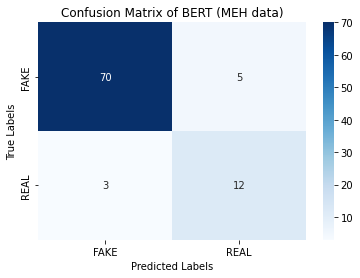

In [29]:
cm_bert = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bert, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BERT (MEH data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_bert_meh')

## Fine-tuning

In [30]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [31]:
# %%time
# from bert import run_classifier
params = {'epochs':[50, 75, 100], 'learning_rate':[2e-5, 3e-5, 1e-5]}

# wrap classifier/regressor in GridSearchCV
clf_bert = GridSearchCV(BertClassifier(validation_fraction=0, max_seq_length=64), 
                   params,
                   cv=3,
                   scoring='accuracy',
                   verbose=True)

# fit gridsearch 
clf_bert.fit(X_train ,y_train)

Building sklearn text classifier...
Building sklearn text classifier...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 16.38it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 15.38it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 14.68it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 14.76it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 14.36it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 14.04it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 13.86it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 13.57it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 13.58it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 13.00it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 12.25it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 11.60it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 11.33it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 11.63it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 11.11it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 10.91it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 10.50it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 10.15it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 10.26it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 10.32it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 10.49it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  9.96it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  9.65it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  9.31it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  9.53it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  9.40it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  9.46it/s]


Building sklearn text classifier...
Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 267, validation data size: 0


Training  : 100%|██████████| 9/9 [00:03<00:00,  2.29it/s, loss=0.089] 


GridSearchCV(cv=3,
             estimator=BertClassifier(max_seq_length=64, validation_fraction=0),
             param_grid={'epochs': [50, 75, 100],
                         'learning_rate': [2e-05, 3e-05, 1e-05]},
             scoring='accuracy', verbose=True)

In [32]:
means = clf_bert.cv_results_['mean_test_score']
stds = clf_bert.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf_bert.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
# best scores
print("\nBest score:", clf_bert.best_score_,"with params:", clf_bert.best_params_)

0.918 (+/-0.046) for {'epochs': 50, 'learning_rate': 2e-05}
0.921 (+/-0.055) for {'epochs': 50, 'learning_rate': 3e-05}
0.918 (+/-0.046) for {'epochs': 50, 'learning_rate': 1e-05}
0.921 (+/-0.049) for {'epochs': 75, 'learning_rate': 2e-05}
0.918 (+/-0.046) for {'epochs': 75, 'learning_rate': 3e-05}
0.914 (+/-0.046) for {'epochs': 75, 'learning_rate': 1e-05}
0.921 (+/-0.037) for {'epochs': 100, 'learning_rate': 2e-05}
0.918 (+/-0.038) for {'epochs': 100, 'learning_rate': 3e-05}
0.918 (+/-0.038) for {'epochs': 100, 'learning_rate': 1e-05}

Best score: 0.9213483146067416 with params: {'epochs': 50, 'learning_rate': 3e-05}


In [33]:
# CUDA device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)
# Print state of GPU
# !nvidia-smi

'Tesla P100-PCIE-16GB'

In [32]:
#define a batch size
batch_size = 5
epochs = 100
learning_rate = 1e-1

In [33]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert_2 instance and the label numbers
model = BERT_Text_Classifier(bert, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

In [34]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 100


100%|██████████| 54/54 [00:03<00:00, 15.92it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.39it/s]


Training Loss: 0.160 dev performance, p:0.918, r:0.985, f1:0.950
current best score is 0.950

 Epoch 2 / 100



100%|██████████| 54/54 [00:03<00:00, 16.09it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.32it/s]


Training Loss: 0.147 dev performance, p:0.984, r:0.926, f1:0.955
current best score is 0.955

 Epoch 3 / 100



100%|██████████| 54/54 [00:03<00:00, 16.06it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.92it/s]


Training Loss: 0.138 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 4 / 100



100%|██████████| 54/54 [00:03<00:00, 15.93it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 86.27it/s]


Training Loss: 0.154 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 5 / 100



100%|██████████| 54/54 [00:03<00:00, 15.75it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 90.77it/s]



Training Loss: 0.148 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 6 / 100


100%|██████████| 54/54 [00:03<00:00, 16.08it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 87.06it/s]


Training Loss: 0.130 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 7 / 100



100%|██████████| 54/54 [00:03<00:00, 15.77it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 85.34it/s]


Training Loss: 0.119 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 8 / 100



100%|██████████| 54/54 [00:03<00:00, 16.07it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.56it/s]


Training Loss: 0.131 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 9 / 100



100%|██████████| 54/54 [00:03<00:00, 16.12it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.53it/s]


Training Loss: 0.119 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 10 / 100



100%|██████████| 54/54 [00:03<00:00, 16.17it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.67it/s]


Training Loss: 0.133 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 11 / 100



100%|██████████| 54/54 [00:03<00:00, 16.13it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.33it/s]


Training Loss: 0.132 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 12 / 100



100%|██████████| 54/54 [00:03<00:00, 16.20it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 81.34it/s]


Training Loss: 0.121 dev performance, p:0.917, r:0.971, f1:0.943

 Epoch 13 / 100



100%|██████████| 54/54 [00:03<00:00, 16.11it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.11it/s]


Training Loss: 0.112 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 14 / 100



100%|██████████| 54/54 [00:03<00:00, 16.18it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 80.68it/s]


Training Loss: 0.122 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 15 / 100



100%|██████████| 54/54 [00:03<00:00, 16.19it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.97it/s]


Training Loss: 0.120 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 16 / 100



100%|██████████| 54/54 [00:03<00:00, 16.19it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.04it/s]


Training Loss: 0.118 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 17 / 100



100%|██████████| 54/54 [00:03<00:00, 16.13it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 85.35it/s]


Training Loss: 0.119 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 18 / 100



100%|██████████| 54/54 [00:03<00:00, 16.27it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.09it/s]


Training Loss: 0.117 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 19 / 100



100%|██████████| 54/54 [00:03<00:00, 16.18it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.35it/s]


Training Loss: 0.119 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 20 / 100



100%|██████████| 54/54 [00:03<00:00, 16.21it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 82.12it/s]


Training Loss: 0.118 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 21 / 100



100%|██████████| 54/54 [00:03<00:00, 16.22it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.64it/s]


Training Loss: 0.112 dev performance, p:0.931, r:0.985, f1:0.957
current best score is 0.957

 Epoch 22 / 100



100%|██████████| 54/54 [00:03<00:00, 16.03it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 85.17it/s]


Training Loss: 0.123 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 23 / 100



100%|██████████| 54/54 [00:03<00:00, 16.19it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.98it/s]


Training Loss: 0.111 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 24 / 100



100%|██████████| 54/54 [00:03<00:00, 16.13it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 79.63it/s]


Training Loss: 0.122 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 25 / 100



100%|██████████| 54/54 [00:03<00:00, 16.14it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 81.21it/s]


Training Loss: 0.116 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 26 / 100



100%|██████████| 54/54 [00:03<00:00, 16.47it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.64it/s]


Training Loss: 0.110 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 27 / 100



100%|██████████| 54/54 [00:03<00:00, 16.37it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 85.09it/s]


Training Loss: 0.119 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 28 / 100



100%|██████████| 54/54 [00:03<00:00, 16.18it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.67it/s]


Training Loss: 0.119 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 29 / 100



100%|██████████| 54/54 [00:03<00:00, 16.20it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.46it/s]


Training Loss: 0.148 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 30 / 100



100%|██████████| 54/54 [00:03<00:00, 16.15it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 86.42it/s]


Training Loss: 0.117 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 31 / 100



100%|██████████| 54/54 [00:03<00:00, 16.14it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 85.01it/s]


Training Loss: 0.117 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 32 / 100



100%|██████████| 54/54 [00:03<00:00, 16.15it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 87.25it/s]


Training Loss: 0.117 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 33 / 100



100%|██████████| 54/54 [00:03<00:00, 15.91it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.86it/s]


Training Loss: 0.115 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 34 / 100



100%|██████████| 54/54 [00:03<00:00, 15.96it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 90.61it/s]



Training Loss: 0.113 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 35 / 100


100%|██████████| 54/54 [00:03<00:00, 16.14it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 89.07it/s]


Training Loss: 0.114 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 36 / 100



100%|██████████| 54/54 [00:03<00:00, 15.89it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 87.74it/s]


Training Loss: 0.123 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 37 / 100



100%|██████████| 54/54 [00:03<00:00, 16.41it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.99it/s]


Training Loss: 0.110 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 38 / 100



100%|██████████| 54/54 [00:03<00:00, 16.23it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 85.47it/s]


Training Loss: 0.114 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 39 / 100



100%|██████████| 54/54 [00:03<00:00, 16.14it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 85.65it/s]


Training Loss: 0.113 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 40 / 100



100%|██████████| 54/54 [00:03<00:00, 16.28it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.78it/s]


Training Loss: 0.111 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 41 / 100



100%|██████████| 54/54 [00:03<00:00, 16.44it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.43it/s]


Training Loss: 0.119 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 42 / 100



100%|██████████| 54/54 [00:03<00:00, 16.22it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.08it/s]


Training Loss: 0.111 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 43 / 100



100%|██████████| 54/54 [00:03<00:00, 16.43it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.03it/s]


Training Loss: 0.108 dev performance, p:0.931, r:0.985, f1:0.957

 Epoch 44 / 100



100%|██████████| 54/54 [00:03<00:00, 16.44it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.94it/s]


Training Loss: 0.116 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 45 / 100



100%|██████████| 54/54 [00:03<00:00, 16.47it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.16it/s]


Training Loss: 0.115 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 46 / 100



100%|██████████| 54/54 [00:03<00:00, 16.50it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.48it/s]


Training Loss: 0.114 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 47 / 100



100%|██████████| 54/54 [00:03<00:00, 16.11it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 80.34it/s]


Training Loss: 0.112 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 48 / 100



100%|██████████| 54/54 [00:03<00:00, 16.25it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.68it/s]


Training Loss: 0.110 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 49 / 100



100%|██████████| 54/54 [00:03<00:00, 16.41it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.20it/s]


Training Loss: 0.121 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 50 / 100



100%|██████████| 54/54 [00:03<00:00, 16.17it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 81.21it/s]


Training Loss: 0.111 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 51 / 100



100%|██████████| 54/54 [00:03<00:00, 16.47it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.37it/s]


Training Loss: 0.151 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 52 / 100



100%|██████████| 54/54 [00:03<00:00, 16.13it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.02it/s]


Training Loss: 0.114 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 53 / 100



100%|██████████| 54/54 [00:03<00:00, 16.15it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.10it/s]


Training Loss: 0.116 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 54 / 100



100%|██████████| 54/54 [00:03<00:00, 16.12it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.88it/s]


Training Loss: 0.113 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 55 / 100



100%|██████████| 54/54 [00:03<00:00, 15.97it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 81.43it/s]


Training Loss: 0.109 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 56 / 100



100%|██████████| 54/54 [00:03<00:00, 16.06it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 87.94it/s]


Training Loss: 0.113 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 57 / 100



100%|██████████| 54/54 [00:03<00:00, 16.17it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 86.88it/s]


Training Loss: 0.116 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 58 / 100



100%|██████████| 54/54 [00:03<00:00, 15.93it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 86.41it/s]


Training Loss: 0.118 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 59 / 100



100%|██████████| 54/54 [00:03<00:00, 16.35it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.81it/s]


Training Loss: 0.110 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 60 / 100



100%|██████████| 54/54 [00:03<00:00, 15.90it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.50it/s]


Training Loss: 0.141 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 61 / 100



100%|██████████| 54/54 [00:03<00:00, 16.11it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 89.20it/s]


Training Loss: 0.129 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 62 / 100



100%|██████████| 54/54 [00:02<00:00, 25.20it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.30it/s]


Training Loss: 0.116 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 63 / 100



100%|██████████| 54/54 [00:01<00:00, 30.75it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.02it/s]


Training Loss: 0.113 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 64 / 100



100%|██████████| 54/54 [00:01<00:00, 30.59it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.03it/s]


Training Loss: 0.109 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 65 / 100



100%|██████████| 54/54 [00:01<00:00, 30.75it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.16it/s]


Training Loss: 0.128 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 66 / 100



100%|██████████| 54/54 [00:01<00:00, 30.80it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.46it/s]


Training Loss: 0.139 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 67 / 100



100%|██████████| 54/54 [00:01<00:00, 30.36it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.17it/s]


Training Loss: 0.147 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 68 / 100



100%|██████████| 54/54 [00:01<00:00, 30.51it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.12it/s]


Training Loss: 0.118 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 69 / 100



100%|██████████| 54/54 [00:01<00:00, 30.67it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.26it/s]


Training Loss: 0.136 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 70 / 100



100%|██████████| 54/54 [00:01<00:00, 30.76it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.82it/s]


Training Loss: 0.115 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 71 / 100



100%|██████████| 54/54 [00:01<00:00, 30.54it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.35it/s]


Training Loss: 0.111 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 72 / 100



100%|██████████| 54/54 [00:01<00:00, 30.25it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.38it/s]


Training Loss: 0.208 dev performance, p:0.919, r:1.000, f1:0.958


current best score is 0.958

 Epoch 73 / 100


100%|██████████| 54/54 [00:01<00:00, 30.53it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.44it/s]


Training Loss: 0.144 dev performance, p:0.917, r:0.971, f1:0.943

 Epoch 74 / 100



100%|██████████| 54/54 [00:01<00:00, 30.40it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.27it/s]


Training Loss: 0.160 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 75 / 100



100%|██████████| 54/54 [00:01<00:00, 30.58it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.02it/s]


Training Loss: 0.192 dev performance, p:0.915, r:0.956, f1:0.935

 Epoch 76 / 100



100%|██████████| 54/54 [00:01<00:00, 28.65it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 109.89it/s]


Training Loss: 0.124 dev performance, p:0.915, r:0.956, f1:0.935

 Epoch 77 / 100



100%|██████████| 54/54 [00:02<00:00, 23.49it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 113.91it/s]


Training Loss: 0.120 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 78 / 100



100%|██████████| 54/54 [00:02<00:00, 26.00it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.85it/s]


Training Loss: 0.120 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 79 / 100



100%|██████████| 54/54 [00:02<00:00, 23.28it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 105.58it/s]


Training Loss: 0.112 dev performance, p:0.917, r:0.971, f1:0.943

 Epoch 80 / 100



100%|██████████| 54/54 [00:02<00:00, 26.40it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.22it/s]


Training Loss: 0.120 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 81 / 100



100%|██████████| 54/54 [00:03<00:00, 17.31it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 80.87it/s]


Training Loss: 0.116 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 82 / 100



100%|██████████| 54/54 [00:03<00:00, 16.12it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.39it/s]


Training Loss: 0.112 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 83 / 100



100%|██████████| 54/54 [00:03<00:00, 16.09it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 82.32it/s]


Training Loss: 0.106 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 84 / 100



100%|██████████| 54/54 [00:03<00:00, 16.18it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 85.85it/s]


Training Loss: 0.111 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 85 / 100



100%|██████████| 54/54 [00:03<00:00, 16.09it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.34it/s]


Training Loss: 0.111 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 86 / 100



100%|██████████| 54/54 [00:03<00:00, 16.13it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.48it/s]


Training Loss: 0.110 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 87 / 100



100%|██████████| 54/54 [00:03<00:00, 16.15it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.95it/s]


Training Loss: 0.113 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 88 / 100



100%|██████████| 54/54 [00:03<00:00, 16.02it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.15it/s]


Training Loss: 0.140 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 89 / 100



100%|██████████| 54/54 [00:03<00:00, 16.00it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.65it/s]


Training Loss: 0.130 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 90 / 100



100%|██████████| 54/54 [00:03<00:00, 16.12it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 85.28it/s]


Training Loss: 0.113 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 91 / 100



100%|██████████| 54/54 [00:03<00:00, 15.93it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 87.55it/s]


Training Loss: 0.112 dev performance, p:0.917, r:0.971, f1:0.943

 Epoch 92 / 100



100%|██████████| 54/54 [00:03<00:00, 15.91it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 86.86it/s]


Training Loss: 0.105 dev performance, p:0.917, r:0.971, f1:0.943

 Epoch 93 / 100



100%|██████████| 54/54 [00:03<00:00, 16.26it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 85.13it/s]


Training Loss: 0.131 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 94 / 100



100%|██████████| 54/54 [00:03<00:00, 15.94it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.35it/s]


Training Loss: 0.131 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 95 / 100



100%|██████████| 54/54 [00:03<00:00, 16.39it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 87.59it/s]


Training Loss: 0.131 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 96 / 100



100%|██████████| 54/54 [00:03<00:00, 16.33it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.28it/s]


Training Loss: 0.110 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 97 / 100



100%|██████████| 54/54 [00:03<00:00, 16.13it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 81.24it/s]


Training Loss: 0.139 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 98 / 100



100%|██████████| 54/54 [00:03<00:00, 16.07it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.60it/s]


Training Loss: 0.110 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 99 / 100



100%|██████████| 54/54 [00:03<00:00, 16.58it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.99it/s]


Training Loss: 0.113 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 100 / 100



100%|██████████| 54/54 [00:03<00:00, 16.42it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.76it/s]


Training Loss: 0.133 dev performance, p:0.918, r:0.985, f1:0.950


In [35]:
model_file = 'MEH_bert_gridsearch.pt'
torch.save(best_model_state, model_file)

In [36]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'MEH_bert_gridsearch.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert_2, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

In [37]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [38]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|██████████| 18/18 [00:00<00:00, 91.17it/s]

{'precision': 0.9493670886075949, 'recall': 1.0, 'f1': 0.974025974025974}


In [39]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       1.00      0.73      0.85        15
           1       0.95      1.00      0.97        75

    accuracy                           0.96        90
   macro avg       0.97      0.87      0.91        90
weighted avg       0.96      0.96      0.95        90



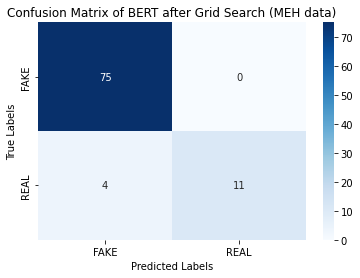

In [40]:
cm_bert_grid = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bert_grid, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BERT after Grid Search (MEH data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_BERT(grid search)_meh')

# BlueBERT
## Initial training

In [41]:
# bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12
# import BERT-base pretrained model
bert_2 = AutoModel.from_pretrained('bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12')
# Load the BERT tokenizer
tokenizer_2 = BertTokenizerFast.from_pretrained('bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12')

Some weights of the model checkpoint at bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
def prepare_X_y(texts, labels):    
    tokenized = tokenizer_2.batch_encode_plus(
        texts,
        padding=True,
        truncation=True
    )
    seq = torch.tensor(tokenized['input_ids'])
    mask = torch.tensor(tokenized['attention_mask'])
    y = torch.tensor(labels)
    return seq, mask, y

train_seq, train_mask, train_y = prepare_X_y(X_train, y_train)
dev_seq, dev_mask, dev_y = prepare_X_y(X_dev, y_dev)
test_seq, test_mask, test_y = prepare_X_y(X_test, y_test)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [43]:
#define a batch size
batch_size = 5
epochs = 20
learning_rate = 1e-1

In [44]:
# wrap tensors
training_data = TensorDataset(train_seq, train_mask, train_y)
dev_data = TensorDataset(dev_seq, dev_mask, dev_y)
# testing_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
sampler = RandomSampler(training_data)

# dataLoader
training_data_loader = DataLoader(training_data, sampler=sampler, batch_size=batch_size)
dev_data_loader = DataLoader(dev_data, batch_size=batch_size) 
# testing_data_loader = DataLoader(testing_data, sampler=sampler, batch_size=batch_size)

In [45]:
# Define the model

class BERT_Text_Classifier(nn.Module):
    
    def __init__(self, bert_2, class_num, bert_dim=768, hidden_dim=512):
      
        super(BERT_Text_Classifier, self).__init__()

        self.bert_2 = bert_2 

        # define a dropout
        self.dropout = nn.Dropout(0.1)

        # use relu
        self.relu =  nn.ReLU()

        # feedforward layer
        self.fc1 = nn.Linear(bert_dim, hidden_dim)

        # Output layer
        self.fc2 = nn.Linear(hidden_dim, class_num)

        #softmax function instance
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, seq, mask):

        # use pretrained bert_2 to read the sequence with the mask (pay attention to which tokens)
        bert_out = self.bert_2(seq, attention_mask=mask)
        
        # print('last_hidden_state', bert_out['last_hidden_state'].size(), 
        #      'pooler_output', bert_out['pooler_output'].size())
        
        lhs = bert_out['pooler_output']
        x = self.fc1(lhs)        
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        # apply softmax activation
        x = self.softmax(x)

        return x

In [46]:
def evaluate(m, evl_loader, eval_labels=[1]):
    from sklearn.metrics import precision_recall_fscore_support
    preds = []
    lbls = []
    print('evaluating...', flush=True)
    for step, batch in enumerate(tqdm(evl_loader)):        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        seq, mask, labels = batch
        with torch.no_grad():
            batch_result = m(seq, mask)
            rets = np.argmax(batch_result.detach().cpu(), axis = 1).tolist()
            preds += rets
            lbls += labels.tolist()
    p, r, f, _ = precision_recall_fscore_support(lbls, preds, labels=eval_labels)
    return {'precision': p[0], 'recall': r[0], 'f1': f[0]}

In [47]:
# function to train the model
def train():
    # dropout activates when in train mode 
    model.train()

    total_loss = 0
    for step, batch in enumerate(tqdm(training_data_loader)):
        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        
        seq, mask, labels = batch
        
        # reset gradients 
        model.zero_grad()        

        # get model outputs
        outputs = model.forward(seq, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(outputs, labels)

        # accumulate loss
        total_loss = total_loss + loss.item()

        # calculate the gradients
        loss.backward()

        # deal with the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

    # calculate average loss
    average_loss = total_loss / len(training_data_loader)
    
    ret = evaluate(model, dev_data_loader)
  
    return average_loss, ret

In [48]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert_2 instance and the label numbers
model = BERT_Text_Classifier(bert_2, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

In [51]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 20


100%|██████████| 54/54 [00:02<00:00, 25.93it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 99.70it/s] 


Training Loss: 0.385 dev performance, p:0.918, r:0.985, f1:0.950
current best score is 0.950

 Epoch 2 / 20



100%|██████████| 54/54 [00:02<00:00, 26.72it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.53it/s]


Training Loss: 0.276 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 3 / 20



100%|██████████| 54/54 [00:02<00:00, 26.66it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.76it/s]


Training Loss: 0.283 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 4 / 20



100%|██████████| 54/54 [00:02<00:00, 25.15it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 88.69it/s]


Training Loss: 0.249 dev performance, p:0.919, r:1.000, f1:0.958
current best score is 0.958

 Epoch 5 / 20



100%|██████████| 54/54 [00:02<00:00, 25.06it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 86.63it/s]


Training Loss: 0.261 dev performance, p:0.917, r:0.971, f1:0.943

 Epoch 6 / 20



100%|██████████| 54/54 [00:02<00:00, 25.00it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 88.43it/s]


Training Loss: 0.267 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 7 / 20



100%|██████████| 54/54 [00:02<00:00, 25.32it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.72it/s]


Training Loss: 0.232 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 8 / 20



100%|██████████| 54/54 [00:01<00:00, 30.22it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.30it/s]


Training Loss: 0.242 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 9 / 20



100%|██████████| 54/54 [00:01<00:00, 30.06it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 108.30it/s]


Training Loss: 0.206 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 10 / 20



100%|██████████| 54/54 [00:01<00:00, 29.78it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.86it/s]


Training Loss: 0.212 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 11 / 20



100%|██████████| 54/54 [00:01<00:00, 30.19it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.54it/s]


Training Loss: 0.189 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 12 / 20



100%|██████████| 54/54 [00:01<00:00, 30.02it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.56it/s]


Training Loss: 0.249 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 13 / 20



100%|██████████| 54/54 [00:01<00:00, 30.29it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.11it/s]


Training Loss: 0.199 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 14 / 20



100%|██████████| 54/54 [00:01<00:00, 30.40it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.12it/s]


Training Loss: 0.192 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 15 / 20



100%|██████████| 54/54 [00:01<00:00, 30.00it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.58it/s]


Training Loss: 0.213 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 16 / 20



100%|██████████| 54/54 [00:01<00:00, 30.14it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 108.62it/s]


Training Loss: 0.253 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 17 / 20



100%|██████████| 54/54 [00:01<00:00, 29.95it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.96it/s]


Training Loss: 0.170 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 18 / 20



100%|██████████| 54/54 [00:01<00:00, 30.03it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.99it/s]


Training Loss: 0.156 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 19 / 20



100%|██████████| 54/54 [00:01<00:00, 30.17it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.12it/s]


Training Loss: 0.152 dev performance, p:0.955, r:0.941, f1:0.948

 Epoch 20 / 20



100%|██████████| 54/54 [00:01<00:00, 29.89it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.48it/s]


Training Loss: 0.286 dev performance, p:0.943, r:0.971, f1:0.957


In [52]:
model_file = 'MEH_bluebert_initial.pt'
torch.save(best_model_state, model_file)

In [53]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'MEH_bluebert_initial.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert_2, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

In [54]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [55]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|██████████| 18/18 [00:00<00:00, 98.60it/s] 

{'precision': 0.9493670886075949, 'recall': 1.0, 'f1': 0.974025974025974}


In [56]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.95      0.99      0.97        75

    accuracy                           0.94        90
   macro avg       0.93      0.86      0.89        90
weighted avg       0.94      0.94      0.94        90



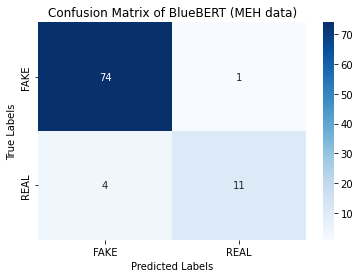

In [57]:
cm_bluebert = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bluebert, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BlueBERT (MEH data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_BlueBERT_meh')

## Fine-tuning

In [58]:
# %%time
# from bert import run_classifier
params = {'epochs':[50, 75, 100], 'learning_rate':[2e-5, 3e-5, 1e-5]}

# wrap classifier/regressor in GridSearchCV
clf_bert = GridSearchCV(BertClassifier(validation_fraction=0, max_seq_length=64), 
                   params,
                   cv=3,
                   scoring='accuracy',
                   verbose=True)

# fit gridsearch 
clf_bert.fit(X_train ,y_train)

Building sklearn text classifier...
Building sklearn text classifier...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.52it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.70it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.59it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.21it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.19it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  7.55it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  7.96it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  7.80it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  7.92it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  7.70it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  7.64it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  7.72it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  7.54it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  7.48it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.77it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.51it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.27it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.40it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.20it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.32it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.00it/s]


Building sklearn text classifier...
Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 267, validation data size: 0


Training  : 100%|██████████| 9/9 [00:03<00:00,  2.29it/s, loss=0.089] 


GridSearchCV(cv=3,
             estimator=BertClassifier(max_seq_length=64, validation_fraction=0),
             param_grid={'epochs': [50, 75, 100],
                         'learning_rate': [2e-05, 3e-05, 1e-05]},
             scoring='accuracy', verbose=True)

In [59]:
means = clf_bert.cv_results_['mean_test_score']
stds = clf_bert.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf_bert.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
# best scores
print("\nBest score:", clf_bert.best_score_,"with params:", clf_bert.best_params_)

0.918 (+/-0.046) for {'epochs': 50, 'learning_rate': 2e-05}
0.921 (+/-0.055) for {'epochs': 50, 'learning_rate': 3e-05}
0.918 (+/-0.046) for {'epochs': 50, 'learning_rate': 1e-05}
0.921 (+/-0.049) for {'epochs': 75, 'learning_rate': 2e-05}
0.918 (+/-0.046) for {'epochs': 75, 'learning_rate': 3e-05}
0.914 (+/-0.046) for {'epochs': 75, 'learning_rate': 1e-05}
0.921 (+/-0.037) for {'epochs': 100, 'learning_rate': 2e-05}
0.918 (+/-0.038) for {'epochs': 100, 'learning_rate': 3e-05}
0.918 (+/-0.038) for {'epochs': 100, 'learning_rate': 1e-05}

Best score: 0.9213483146067416 with params: {'epochs': 50, 'learning_rate': 3e-05}


In [58]:
#define a batch size
batch_size = 5
epochs = 100
learning_rate = 1e-1

In [59]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert_2 instance and the label numbers
model = BERT_Text_Classifier(bert_2, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

In [60]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 100


100%|██████████| 54/54 [00:05<00:00, 10.57it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 62.64it/s]


Training Loss: 0.165 dev performance, p:0.931, r:0.985, f1:0.957
current best score is 0.957

 Epoch 2 / 100



100%|██████████| 54/54 [00:05<00:00, 10.35it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 61.98it/s]


Training Loss: 0.134 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 3 / 100



100%|██████████| 54/54 [00:05<00:00, 10.65it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 61.37it/s]


Training Loss: 0.138 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 4 / 100



100%|██████████| 54/54 [00:05<00:00, 10.52it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 61.19it/s]


Training Loss: 0.153 dev performance, p:0.984, r:0.912, f1:0.947

 Epoch 5 / 100



100%|██████████| 54/54 [00:05<00:00, 10.47it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 62.26it/s]


Training Loss: 0.125 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 6 / 100



100%|██████████| 54/54 [00:05<00:00, 10.63it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 65.74it/s]


Training Loss: 0.122 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 7 / 100



100%|██████████| 54/54 [00:05<00:00, 10.68it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 62.62it/s]


Training Loss: 0.127 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 8 / 100



100%|██████████| 54/54 [00:05<00:00, 10.58it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 62.29it/s]


Training Loss: 0.119 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 9 / 100



100%|██████████| 54/54 [00:05<00:00, 10.55it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 62.36it/s]


Training Loss: 0.119 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 10 / 100



100%|██████████| 54/54 [00:05<00:00, 10.65it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 59.66it/s]


Training Loss: 0.120 dev performance, p:0.917, r:0.971, f1:0.943

 Epoch 11 / 100



100%|██████████| 54/54 [00:05<00:00, 10.27it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 60.25it/s]


Training Loss: 0.119 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 12 / 100



100%|██████████| 54/54 [00:05<00:00, 10.66it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 61.17it/s]


Training Loss: 0.116 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 13 / 100



100%|██████████| 54/54 [00:05<00:00, 10.63it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 62.52it/s]


Training Loss: 0.121 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 14 / 100



100%|██████████| 54/54 [00:05<00:00, 10.44it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 60.95it/s]


Training Loss: 0.111 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 15 / 100



100%|██████████| 54/54 [00:05<00:00, 10.62it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 62.50it/s]


Training Loss: 0.151 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 16 / 100



100%|██████████| 54/54 [00:05<00:00, 10.55it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 61.64it/s]


Training Loss: 0.111 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 17 / 100



100%|██████████| 54/54 [00:05<00:00, 10.56it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 59.98it/s]



Training Loss: 0.120 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 18 / 100


100%|██████████| 54/54 [00:05<00:00, 10.53it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 61.42it/s]


Training Loss: 0.120 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 19 / 100



100%|██████████| 54/54 [00:05<00:00, 10.64it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 62.03it/s]


Training Loss: 0.109 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 20 / 100



100%|██████████| 54/54 [00:05<00:00, 10.51it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 64.19it/s]


Training Loss: 0.123 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 21 / 100



100%|██████████| 54/54 [00:05<00:00, 10.53it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 63.43it/s]


Training Loss: 0.117 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 22 / 100



100%|██████████| 54/54 [00:05<00:00, 10.61it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 61.41it/s]


Training Loss: 0.116 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 23 / 100



100%|██████████| 54/54 [00:05<00:00, 10.15it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 62.02it/s]


Training Loss: 0.149 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 24 / 100



100%|██████████| 54/54 [00:05<00:00, 10.63it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 63.91it/s]


Training Loss: 0.122 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 25 / 100



100%|██████████| 54/54 [00:05<00:00, 10.57it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 65.47it/s]


Training Loss: 0.117 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 26 / 100



100%|██████████| 54/54 [00:05<00:00, 10.58it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 62.22it/s]


Training Loss: 0.116 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 27 / 100



100%|██████████| 54/54 [00:05<00:00, 10.73it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 61.63it/s]


Training Loss: 0.115 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 28 / 100



100%|██████████| 54/54 [00:05<00:00, 10.52it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 62.44it/s]


Training Loss: 0.111 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 29 / 100



100%|██████████| 54/54 [00:05<00:00, 10.41it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 63.44it/s]


Training Loss: 0.121 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 30 / 100



100%|██████████| 54/54 [00:04<00:00, 11.13it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 68.98it/s]


Training Loss: 0.118 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 31 / 100



100%|██████████| 54/54 [00:03<00:00, 14.44it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 82.51it/s]


Training Loss: 0.114 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 32 / 100



100%|██████████| 54/54 [00:03<00:00, 15.85it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.66it/s]


Training Loss: 0.111 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 33 / 100



100%|██████████| 54/54 [00:03<00:00, 16.09it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 82.96it/s]


Training Loss: 0.121 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 34 / 100



100%|██████████| 54/54 [00:03<00:00, 16.02it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 85.17it/s]


Training Loss: 0.116 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 35 / 100



100%|██████████| 54/54 [00:03<00:00, 16.11it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 87.16it/s]


Training Loss: 0.116 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 36 / 100



100%|██████████| 54/54 [00:03<00:00, 15.96it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 86.37it/s]


Training Loss: 0.113 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 37 / 100



100%|██████████| 54/54 [00:03<00:00, 15.87it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 87.06it/s]


Training Loss: 0.112 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 38 / 100



100%|██████████| 54/54 [00:03<00:00, 16.05it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 87.12it/s]


Training Loss: 0.111 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 39 / 100



100%|██████████| 54/54 [00:03<00:00, 15.89it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 86.61it/s]


Training Loss: 0.116 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 40 / 100



100%|██████████| 54/54 [00:03<00:00, 15.92it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 85.85it/s]


Training Loss: 0.110 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 41 / 100



100%|██████████| 54/54 [00:03<00:00, 16.37it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.09it/s]


Training Loss: 0.129 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 42 / 100



100%|██████████| 54/54 [00:03<00:00, 15.99it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 88.85it/s]


Training Loss: 0.138 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 43 / 100



100%|██████████| 54/54 [00:03<00:00, 15.89it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 87.05it/s]


Training Loss: 0.142 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 44 / 100



100%|██████████| 54/54 [00:03<00:00, 16.28it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 87.72it/s]


Training Loss: 0.122 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 45 / 100



100%|██████████| 54/54 [00:03<00:00, 16.01it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.17it/s]


Training Loss: 0.124 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 46 / 100



100%|██████████| 54/54 [00:03<00:00, 16.17it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.23it/s]


Training Loss: 0.107 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 47 / 100



100%|██████████| 54/54 [00:03<00:00, 16.07it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 79.78it/s]


Training Loss: 0.117 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 48 / 100



100%|██████████| 54/54 [00:03<00:00, 16.08it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 86.71it/s]


Training Loss: 0.119 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 49 / 100



100%|██████████| 54/54 [00:03<00:00, 15.95it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 87.18it/s]


Training Loss: 0.111 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 50 / 100



100%|██████████| 54/54 [00:03<00:00, 16.31it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.78it/s]


Training Loss: 0.114 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 51 / 100



100%|██████████| 54/54 [00:03<00:00, 15.96it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 86.77it/s]


Training Loss: 0.118 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 52 / 100



100%|██████████| 54/54 [00:03<00:00, 15.95it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 87.02it/s]


Training Loss: 0.112 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 53 / 100



100%|██████████| 54/54 [00:03<00:00, 16.29it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 86.84it/s]


Training Loss: 0.110 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 54 / 100



100%|██████████| 54/54 [00:03<00:00, 15.95it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 85.98it/s]


Training Loss: 0.108 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 55 / 100



100%|██████████| 54/54 [00:03<00:00, 15.98it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 86.34it/s]


Training Loss: 0.114 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 56 / 100



100%|██████████| 54/54 [00:03<00:00, 16.20it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.67it/s]


Training Loss: 0.117 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 57 / 100



100%|██████████| 54/54 [00:03<00:00, 16.15it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.75it/s]


Training Loss: 0.118 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 58 / 100



100%|██████████| 54/54 [00:03<00:00, 16.22it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.55it/s]


Training Loss: 0.120 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 59 / 100



100%|██████████| 54/54 [00:03<00:00, 16.16it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 79.24it/s]


Training Loss: 0.124 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 60 / 100



100%|██████████| 54/54 [00:03<00:00, 16.18it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.78it/s]


Training Loss: 0.132 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 61 / 100



100%|██████████| 54/54 [00:03<00:00, 16.13it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 82.95it/s]


Training Loss: 0.136 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 62 / 100



100%|██████████| 54/54 [00:03<00:00, 17.16it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.60it/s]


Training Loss: 0.112 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 63 / 100



100%|██████████| 54/54 [00:02<00:00, 22.11it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 101.67it/s]


Training Loss: 0.118 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 64 / 100



100%|██████████| 54/54 [00:01<00:00, 28.06it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.12it/s]


Training Loss: 0.109 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 65 / 100



100%|██████████| 54/54 [00:01<00:00, 30.57it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.90it/s]


Training Loss: 0.117 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 66 / 100



100%|██████████| 54/54 [00:02<00:00, 19.74it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 79.19it/s]


Training Loss: 0.109 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 67 / 100



100%|██████████| 54/54 [00:03<00:00, 15.96it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.51it/s]


Training Loss: 0.115 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 68 / 100



100%|██████████| 54/54 [00:03<00:00, 15.99it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 82.16it/s]


Training Loss: 0.112 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 69 / 100



100%|██████████| 54/54 [00:03<00:00, 16.05it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 82.93it/s]


Training Loss: 0.116 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 70 / 100



100%|██████████| 54/54 [00:03<00:00, 16.07it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 78.25it/s]


Training Loss: 0.110 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 71 / 100



100%|██████████| 54/54 [00:03<00:00, 16.07it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 76.97it/s]


Training Loss: 0.113 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 72 / 100



100%|██████████| 54/54 [00:03<00:00, 15.96it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 82.92it/s]


Training Loss: 0.110 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 73 / 100



100%|██████████| 54/54 [00:03<00:00, 16.08it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.23it/s]


Training Loss: 0.114 dev performance, p:0.917, r:0.971, f1:0.943

 Epoch 74 / 100



100%|██████████| 54/54 [00:03<00:00, 16.01it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.99it/s]


Training Loss: 0.108 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 75 / 100



100%|██████████| 54/54 [00:03<00:00, 16.03it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 82.78it/s]


Training Loss: 0.112 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 76 / 100



100%|██████████| 54/54 [00:03<00:00, 15.98it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 87.42it/s]


Training Loss: 0.110 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 77 / 100



100%|██████████| 54/54 [00:03<00:00, 15.81it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 85.88it/s]


Training Loss: 0.114 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 78 / 100



100%|██████████| 54/54 [00:03<00:00, 16.16it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 86.32it/s]


Training Loss: 0.118 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 79 / 100



100%|██████████| 54/54 [00:03<00:00, 15.82it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 87.22it/s]


Training Loss: 0.119 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 80 / 100



100%|██████████| 54/54 [00:03<00:00, 15.92it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 80.32it/s]


Training Loss: 0.109 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 81 / 100



100%|██████████| 54/54 [00:03<00:00, 16.13it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 80.03it/s]


Training Loss: 0.110 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 82 / 100



100%|██████████| 54/54 [00:03<00:00, 16.01it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.07it/s]


Training Loss: 0.112 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 83 / 100



100%|██████████| 54/54 [00:03<00:00, 15.98it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.37it/s]


Training Loss: 0.113 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 84 / 100



100%|██████████| 54/54 [00:03<00:00, 16.30it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.22it/s]


Training Loss: 0.112 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 85 / 100



100%|██████████| 54/54 [00:03<00:00, 15.94it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.59it/s]


Training Loss: 0.119 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 86 / 100



100%|██████████| 54/54 [00:03<00:00, 15.89it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 86.08it/s]


Training Loss: 0.109 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 87 / 100



100%|██████████| 54/54 [00:03<00:00, 16.12it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 87.36it/s]


Training Loss: 0.111 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 88 / 100



100%|██████████| 54/54 [00:03<00:00, 15.84it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 86.08it/s]


Training Loss: 0.112 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 89 / 100



100%|██████████| 54/54 [00:03<00:00, 16.03it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 81.96it/s]


Training Loss: 0.114 dev performance, p:0.917, r:0.971, f1:0.943

 Epoch 90 / 100



100%|██████████| 54/54 [00:03<00:00, 16.14it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 78.52it/s]


Training Loss: 0.117 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 91 / 100



100%|██████████| 54/54 [00:03<00:00, 16.16it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.14it/s]


Training Loss: 0.107 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 92 / 100



100%|██████████| 54/54 [00:03<00:00, 16.18it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.16it/s]


Training Loss: 0.107 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 93 / 100



100%|██████████| 54/54 [00:03<00:00, 15.88it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.64it/s]


Training Loss: 0.116 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 94 / 100



100%|██████████| 54/54 [00:03<00:00, 16.13it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 81.12it/s]


Training Loss: 0.115 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 95 / 100



100%|██████████| 54/54 [00:03<00:00, 16.18it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 82.63it/s]


Training Loss: 0.112 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 96 / 100



100%|██████████| 54/54 [00:03<00:00, 15.95it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 83.47it/s]


Training Loss: 0.110 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 97 / 100



100%|██████████| 54/54 [00:03<00:00, 16.06it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 82.78it/s]


Training Loss: 0.105 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 98 / 100



100%|██████████| 54/54 [00:03<00:00, 16.21it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 79.42it/s]


Training Loss: 0.112 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 99 / 100



100%|██████████| 54/54 [00:03<00:00, 16.15it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 79.91it/s]


Training Loss: 0.110 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 100 / 100



100%|██████████| 54/54 [00:03<00:00, 16.20it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.32it/s]


Training Loss: 0.105 dev performance, p:0.918, r:0.985, f1:0.950


In [61]:
model_file = 'MEH_bluebert_gridsearch.pt'
torch.save(best_model_state, model_file)

In [62]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'MEH_bluebert_gridsearch.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert_2, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

In [63]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [64]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|██████████| 18/18 [00:00<00:00, 90.57it/s]


{'precision': 0.9375, 'recall': 1.0, 'f1': 0.967741935483871}


In [65]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80        15
           1       0.94      1.00      0.97        75

    accuracy                           0.94        90
   macro avg       0.97      0.83      0.88        90
weighted avg       0.95      0.94      0.94        90



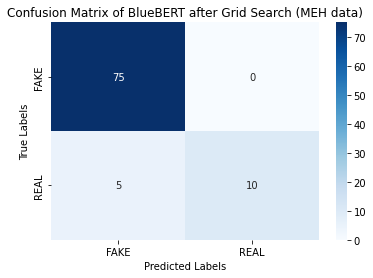

In [66]:
cm_bert = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bert, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BlueBERT after Grid Search (MEH data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_BlueBERT(grid search)_meh')